# Picture

# Title

# Overview

Data provided by https://www.kaggle.com/vicsuperman/prediction-of-music-genre. The full list of genres included in the CSV are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.

In [1]:
# figure out how to put Kaggle link professionally

# Business Problem

Help record labels & artists/producers determine what qualities they should consider when releasing their music on streaming platforms based on spotify's audio features. 

Questions to consider:

* What audio features makes a song popular?
* Which genre should a producer focus on based popularity?

* Why are these questions important from a business perspective?
* What popular artists do differently with their audio features vs. non popular artists
* What makes a song danceable (relevant for clubs etc)
* 

In [2]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer, 
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
                             
)
# import on PC
# # For plotting the tree.
# from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
# from IPython.display import Image


import joblib
import xgboost as xgb
from xgboost import plot_importance

# Helper Functions

In [3]:
def get_value_counts(data):
    for count in data.columns:
        print(count)
        print(data[count].value_counts())
        print('                                                  ')
    return count


def convert_dtype(data,dtype):
    data = data.astype(dtype)
    return data

def make_plot_count(col, data, order = None):
    sns.countplot(x = col, data = data, palette = 'icefire_r', order = order)
    plt.title(f'Frequency in {col}')
    plt.show()

# Data Understanding

In [4]:
df = pd.read_csv("data/music_genre.csv")
df.shape

(50005, 18)

In [5]:
# 5 rows have missing information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [6]:
df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')

## Spotify's Audio Features

Below are the meaning behind Spotify's Audio Features based on their Web API audio features reference.

* **popularity**: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* **duration_ms**: The duration of the track in milliseconds.

* **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

* **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

* **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

* **obtained_date**: date the song was obtained (need to change to release_date)

* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

* **music_genre**: A list of the genres the artist is associated with. If not yet classified, the array is empty.




In [7]:
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [67]:
df.unique

AttributeError: 'DataFrame' object has no attribute 'unique'

In [8]:
# Spotify's API

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 

client_id = "23dad63633fd472980bda54dc327dbf5"
client_secret = "b55df1d149b24dd6835e52136803f61e"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

In [9]:
# look at all the columns value counts
# 2489 entries with an empty_field as a artist name
# 2980 entiries with '?' for tempo
get_value_counts(df)

instance_id
69127.0    1
54606.0    1
77158.0    1
28359.0    1
90011.0    1
          ..
67931.0    1
47596.0    1
70990.0    1
33535.0    1
53248.0    1
Name: instance_id, Length: 50000, dtype: int64
                                                  
artist_name
empty_field                   2489
Nobuo Uematsu                  429
Wolfgang Amadeus Mozart        402
Ludwig van Beethoven           317
Johann Sebastian Bach          314
                              ... 
The Wanton Bishops               1
Harlem Jazz Guitar Quartet       1
Candiria                         1
Archie Bronson Outfit            1
Nate Harasim                     1
Name: artist_name, Length: 6863, dtype: int64
                                                  
track_name
Home                                                                              16
Forever                                                                           15
Without You                                                             

'music_genre'

## Data Cleaning

In [10]:
# Check the number of duplicates in this dataset
df.duplicated().value_counts()

False    50001
True         4
dtype: int64

In [11]:
# looks like the duplicates are mostly missing values
df[df.duplicated()]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# drop all the rows that have missing information
df.dropna(axis=0, inplace= True)

# drop date obtained & instance_id
df.drop(columns = ['obtained_date', 'instance_id'], inplace = True)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       50000 non-null  object 
 1   track_name        50000 non-null  object 
 2   popularity        50000 non-null  float64
 3   acousticness      50000 non-null  float64
 4   danceability      50000 non-null  float64
 5   duration_ms       50000 non-null  float64
 6   energy            50000 non-null  float64
 7   instrumentalness  50000 non-null  float64
 8   key               50000 non-null  object 
 9   liveness          50000 non-null  float64
 10  loudness          50000 non-null  float64
 11  mode              50000 non-null  object 
 12  speechiness       50000 non-null  float64
 13  tempo             50000 non-null  object 
 14  valence           50000 non-null  float64
 15  music_genre       50000 non-null  object 
dtypes: float64(10), object(6)
memory usage: 

### Tempos

* Exploring the missing tempos
* Converting dtype to float

In [14]:
df[df['tempo'] == '?']

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.6140,Electronic
32,PEEKABOO,Arrival,45.0,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,0.1380,Electronic
35,Fabian Mazur,If U Wanted To,33.0,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,0.2390,Electronic
36,Wax Tailor,The Games You Play,45.0,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,0.7270,Electronic
39,Dahu,Vessel,37.0,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,0.0618,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,Big Sean,Bigger Than Me,58.0,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,0.1440,Hip-Hop
49964,Millonario,Rayas de Patrón,59.0,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,0.8860,Hip-Hop
49967,MadeinTYO,I Want (feat. 2 Chainz),62.0,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,0.2210,Hip-Hop
49976,Big Sean,Sunday Morning Jetpack,52.0,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,0.5890,Hip-Hop


In [15]:
# 4980 entries that have missing tempo info, that's a lot since it is an important feature

missing_tempo = df[df['tempo'] == '?']
missing_tempo

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.6140,Electronic
32,PEEKABOO,Arrival,45.0,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,0.1380,Electronic
35,Fabian Mazur,If U Wanted To,33.0,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,0.2390,Electronic
36,Wax Tailor,The Games You Play,45.0,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,0.7270,Electronic
39,Dahu,Vessel,37.0,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,0.0618,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,Big Sean,Bigger Than Me,58.0,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,0.1440,Hip-Hop
49964,Millonario,Rayas de Patrón,59.0,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,0.8860,Hip-Hop
49967,MadeinTYO,I Want (feat. 2 Chainz),62.0,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,0.2210,Hip-Hop
49976,Big Sean,Sunday Morning Jetpack,52.0,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,0.5890,Hip-Hop


In [16]:
get_value_counts(missing_tempo)

artist_name
empty_field                260
Nobuo Uematsu               42
Wolfgang Amadeus Mozart     37
Ludwig van Beethoven        30
Frédéric Chopin             29
                          ... 
Trevor Daniel                1
Dr. Lonnie Smith             1
Lorne Greene                 1
Wagon Christ                 1
Larry Carlton                1
Name: artist_name, Length: 2368, dtype: int64
                                                  
track_name
Closer                                                             3
Crazy                                                              3
The Light                                                          3
Paradise                                                           3
Smile                                                              3
                                                                  ..
恋人募集中(仮)                                                           1
Unaccompanied Cello Suite No. 5 in C Minor, BWV 1011: Al

'music_genre'

In [17]:
missing_tempo['track_name'].value_counts().head(100)

Closer               3
Crazy                3
The Light            3
Paradise             3
Smile                3
                    ..
Voices               2
Kids                 2
Asylum               2
Can't Help Myself    2
Higher               2
Name: track_name, Length: 100, dtype: int64

In [18]:
missing_tempo[missing_tempo['track_name'] == '14U+14ME - Single Edit']

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
1415,The Presets,14U+14ME - Single Edit,45.0,0.039,0.698,210507.0,0.687,0.0358,A#,0.165,-7.695,Minor,0.063,?,0.167,Electronic


In [19]:
# maybe add this to end or future findings
track = sp.search('14U+14ME - Single Edit', type = 'track', market = 'US')
track

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=14U%2B14ME+-+Single+Edit&type=track&market=US&offset=0&limit=10',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1zTAQ6zkGz2L2i6lfR30EX'},
       'href': 'https://api.spotify.com/v1/artists/1zTAQ6zkGz2L2i6lfR30EX',
       'id': '1zTAQ6zkGz2L2i6lfR30EX',
       'name': 'The Presets',
       'type': 'artist',
       'uri': 'spotify:artist:1zTAQ6zkGz2L2i6lfR30EX'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/1P9eUdjW6TJZwXGbwPJ78b'},
     'href': 'https://api.spotify.com/v1/albums/1P9eUdjW6TJZwXGbwPJ78b',
     'id': '1P9eUdjW6TJZwXGbwPJ78b',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b273039533c13cfa4b1b8fbf0ec3',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e02039533c13cfa4b1b8fbf0ec3',
       'width': 300},
      {'height': 64,
       '

In [20]:
# maybe add this to end or future findings
# audio features for '14U+14ME - Single Edit'
sp.audio_features('https://open.spotify.com/track/1rr6EJrXGpk4uJsCwVBOem')

[{'danceability': 0.697,
  'energy': 0.688,
  'key': 6,
  'loudness': -7.771,
  'mode': 1,
  'speechiness': 0.0642,
  'acousticness': 0.0515,
  'instrumentalness': 0.0221,
  'liveness': 0.164,
  'valence': 0.121,
  'tempo': 127.971,
  'type': 'audio_features',
  'id': '1rr6EJrXGpk4uJsCwVBOem',
  'uri': 'spotify:track:1rr6EJrXGpk4uJsCwVBOem',
  'track_href': 'https://api.spotify.com/v1/tracks/1rr6EJrXGpk4uJsCwVBOem',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1rr6EJrXGpk4uJsCwVBOem',
  'duration_ms': 210507,
  'time_signature': 4}]

Searching through Spotify's audiotrack search function. There seems to be some inconsistencies with this dataset. Also the tempo is given in on their dictionary. (Add this to conclusion)

In [21]:
missing_tempo.sort_values('popularity', ascending = False).head(100)

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
47596,Paulo Londra,Adan y Eva,95.0,0.32300,0.767,258639.0,0.709,0.000000,C#,0.0676,-4.470,Major,0.3360,?,0.7200,Hip-Hop
35822,Imagine Dragons,Believer,89.0,0.06220,0.776,204347.0,0.780,0.000000,A#,0.0810,-4.374,Minor,0.1280,?,0.6660,Rock
26495,Logic,Keanu Reeves,87.0,0.05910,0.710,225987.0,0.888,0.000000,D,0.1340,-6.457,Major,0.2350,?,0.8160,Rap
49259,Metro Boomin,Space Cadet (feat. Gunna),87.0,0.36800,0.901,203267.0,0.464,0.000017,F,0.2380,-9.789,Minor,0.0645,?,0.6380,Hip-Hop
49213,Future,Fine China,85.0,0.04840,0.656,141587.0,0.542,0.000000,G,0.1260,-7.358,Major,0.3230,?,0.5510,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29161,Eminem,Stepping Stone,73.0,0.03050,0.616,309638.0,0.684,0.000000,G,0.3760,-6.032,Major,0.3110,?,0.3120,Rap
46902,Drake,Emotionless,73.0,0.02490,0.413,-1.0,0.677,0.000000,C#,0.0793,-5.120,Major,0.2550,?,0.0845,Hip-Hop
45733,Offset,On Fleek (feat. Quavo),73.0,0.24300,0.872,229587.0,0.472,0.000002,A,0.0902,-8.217,Major,0.2050,?,0.2550,Hip-Hop
28227,Drake,Elevate,73.0,0.01500,0.758,184960.0,0.474,0.000000,C#,0.1160,-8.720,Major,0.1460,?,0.0541,Rap


In [22]:
missing_tempo['popular_song'] = missing_tempo['popularity'].map(lambda x: 1 if x >= 50 else 0)

<ipython-input-22-39777c100948>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_tempo['popular_song'] = missing_tempo['popularity'].map(lambda x: 1 if x >= 50 else 0)


In [23]:
missing_tempo

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,popular_song
5,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.6140,Electronic,0
32,PEEKABOO,Arrival,45.0,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,0.1380,Electronic,0
35,Fabian Mazur,If U Wanted To,33.0,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,0.2390,Electronic,0
36,Wax Tailor,The Games You Play,45.0,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,0.7270,Electronic,0
39,Dahu,Vessel,37.0,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,0.0618,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,Big Sean,Bigger Than Me,58.0,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,0.1440,Hip-Hop,1
49964,Millonario,Rayas de Patrón,59.0,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,0.8860,Hip-Hop,1
49967,MadeinTYO,I Want (feat. 2 Chainz),62.0,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,0.2210,Hip-Hop,1
49976,Big Sean,Sunday Morning Jetpack,52.0,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,0.5890,Hip-Hop,1


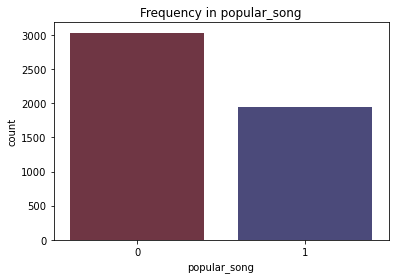

In [24]:
make_plot_count('popular_song',missing_tempo)

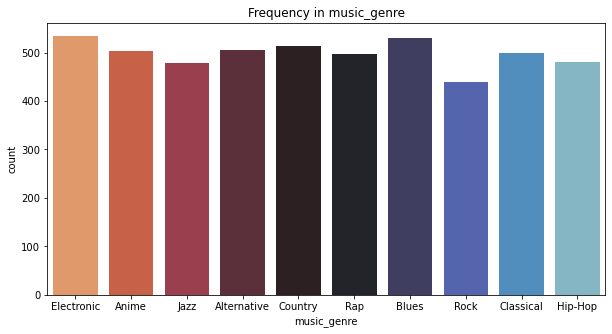

In [25]:
plt.figure(figsize = (10, 5))
make_plot_count('music_genre',missing_tempo)

For the sake of time and simplicity we will drop the tracks that have missing values for tempos. Since tracks tempos are created uniquely by the artist it would not make sense to set them to the median, mode, or mean.

In [26]:
df.drop(df[df['tempo'] == '?'].index, inplace = True)
df.shape

(45020, 16)

In [27]:
df['tempo'] = convert_dtype(df['tempo'],'float')

In [28]:
# round the tempo decimal places to 3 decimal places
df['tempo'] = np.round(df['tempo'], decimals = 3)
df['tempo'].value_counts

<bound method IndexOpsMixin.value_counts of 0        100.889
1        115.002
2        127.994
3        128.014
4        145.036
          ...   
50000     98.028
50001    122.043
50002    131.079
50003     75.886
50004     99.201
Name: tempo, Length: 45020, dtype: float64>

### Popularity

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45020 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       45020 non-null  object 
 1   track_name        45020 non-null  object 
 2   popularity        45020 non-null  float64
 3   acousticness      45020 non-null  float64
 4   danceability      45020 non-null  float64
 5   duration_ms       45020 non-null  float64
 6   energy            45020 non-null  float64
 7   instrumentalness  45020 non-null  float64
 8   key               45020 non-null  object 
 9   liveness          45020 non-null  float64
 10  loudness          45020 non-null  float64
 11  mode              45020 non-null  object 
 12  speechiness       45020 non-null  float64
 13  tempo             45020 non-null  float64
 14  valence           45020 non-null  float64
 15  music_genre       45020 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [30]:
df['popularity'].value_counts()

52.0    1187
54.0    1179
53.0    1170
55.0    1129
50.0    1127
        ... 
94.0       1
97.0       1
99.0       1
92.0       1
95.0       1
Name: popularity, Length: 99, dtype: int64

In [31]:
df['popularity'] = convert_dtype(df['popularity'],'int64')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45020 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       45020 non-null  object 
 1   track_name        45020 non-null  object 
 2   popularity        45020 non-null  int64  
 3   acousticness      45020 non-null  float64
 4   danceability      45020 non-null  float64
 5   duration_ms       45020 non-null  float64
 6   energy            45020 non-null  float64
 7   instrumentalness  45020 non-null  float64
 8   key               45020 non-null  object 
 9   liveness          45020 non-null  float64
 10  loudness          45020 non-null  float64
 11  mode              45020 non-null  object 
 12  speechiness       45020 non-null  float64
 13  tempo             45020 non-null  float64
 14  valence           45020 non-null  float64
 15  music_genre       45020 non-null  object 
dtypes: float64(10), int64(1), object(5)
memo

In [33]:
df['popular_song'] = df['popularity'].map(lambda x: 1 if x >= 50 else 0)
df

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,popular_song
0,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic,0
1,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic,0
2,Dillon Francis,Hurricane,28,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic,0
3,Dubloadz,Nitro,34,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic,0
4,What So Not,Divide & Conquer,32,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,BEXEY,GO GETTA,59,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.028,0.330,Hip-Hop,1
50001,Roy Woods,Drama (feat. Drake),72,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.043,0.113,Hip-Hop,1
50002,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop,1
50003,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop,1


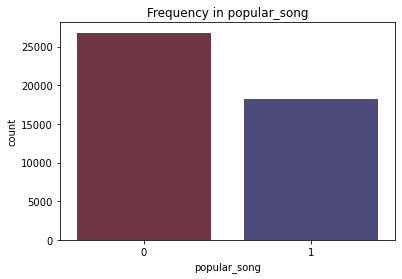

In [34]:
make_plot_count('popular_song',df)

There's a class imbalance between popular and not popular.

In [35]:
get_value_counts(df)

artist_name
empty_field                2229
Nobuo Uematsu               387
Wolfgang Amadeus Mozart     365
Ludwig van Beethoven        287
Johann Sebastian Bach       286
                           ... 
Captain & Tennille            1
Papoose                       1
Lalo Schifrin                 1
MC Davo                       1
In Her Own Words              1
Name: artist_name, Length: 6603, dtype: int64
                                                  
track_name
Home                                                                              16
Forever                                                                           14
Without You                                                                       13
Summertime                                                                        12
Wake Up                                                                           12
                                                                                  ..
Bach: Cello Suite 

'popular_song'

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45020 entries, 0 to 50004
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       45020 non-null  object 
 1   track_name        45020 non-null  object 
 2   popularity        45020 non-null  int64  
 3   acousticness      45020 non-null  float64
 4   danceability      45020 non-null  float64
 5   duration_ms       45020 non-null  float64
 6   energy            45020 non-null  float64
 7   instrumentalness  45020 non-null  float64
 8   key               45020 non-null  object 
 9   liveness          45020 non-null  float64
 10  loudness          45020 non-null  float64
 11  mode              45020 non-null  object 
 12  speechiness       45020 non-null  float64
 13  tempo             45020 non-null  float64
 14  valence           45020 non-null  float64
 15  music_genre       45020 non-null  object 
 16  popular_song      45020 non-null  int64 

### Duration_ms
* What does it mean to have a track duration of -1.0 millisecond?

In [37]:
df.duration_ms.value_counts()

-1.0         4460
 240000.0      31
 192000.0      28
 180000.0      26
 185600.0      17
             ... 
 193425.0       1
 189597.0       1
 204056.0       1
 187671.0       1
 171363.0       1
Name: duration_ms, Length: 24280, dtype: int64

In [38]:
negative_one = df[df['duration_ms'] == -1.0]
negative_one

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,popular_song
0,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,0.7590,Electronic,0
13,DJ Shadow,Broken Levee Blues,31,0.86000,0.737,-1.0,0.405,0.036100,A,0.1730,-10.536,Minor,0.0424,154.745,0.6470,Electronic,0
16,San Holo,One Thing,59,0.13600,0.336,-1.0,0.746,0.000000,C#,0.7370,-4.315,Minor,0.0685,151.756,0.2100,Electronic,1
24,The Prodigy,Diesel Power,56,0.06800,0.725,-1.0,0.877,0.000036,C,0.0900,-3.496,Major,0.0646,105.919,0.0977,Electronic,1
40,The Presets,Ghosts,36,0.18100,0.611,-1.0,0.676,0.000005,C#,0.1390,-9.113,Major,0.0461,139.959,0.5730,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49956,empty_field,What You Like (feat. Ty Dolla $ign & Wiz Khalifa),52,0.13300,0.867,-1.0,0.618,0.000002,B,0.1280,-4.956,Minor,0.0614,140.005,0.8570,Hip-Hop,1
49969,Bone Thugs-N-Harmony,No Surrender,47,0.01270,0.706,-1.0,0.787,0.000000,A,0.2650,-5.314,Major,0.0888,85.963,0.2430,Hip-Hop,0
49979,Young Dolph,Thinking Out Loud,47,0.48300,0.789,-1.0,0.452,0.000000,B,0.0892,-7.538,Minor,0.4800,140.101,0.2840,Hip-Hop,0
49981,Mac Miller,Party On Fifth Ave.,60,0.06350,0.594,-1.0,0.823,0.000000,A,0.0950,-5.210,Major,0.3320,97.101,0.6630,Hip-Hop,1


In [39]:
track = sp.search('Party On Fifth Ave.', type = 'track', market = 'US')
track

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Party+On+Fifth+Ave.&type=track&market=US&offset=0&limit=10',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4LLpKhyESsyAXpc4laK94U'},
       'href': 'https://api.spotify.com/v1/artists/4LLpKhyESsyAXpc4laK94U',
       'id': '4LLpKhyESsyAXpc4laK94U',
       'name': 'Mac Miller',
       'type': 'artist',
       'uri': 'spotify:artist:4LLpKhyESsyAXpc4laK94U'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/6VhDYmsjHqRxKXd0z7hmXI'},
     'href': 'https://api.spotify.com/v1/albums/6VhDYmsjHqRxKXd0z7hmXI',
     'id': '6VhDYmsjHqRxKXd0z7hmXI',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b27382a2fe856191e66bc0b9c6ce',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e0282a2fe856191e66bc0b9c6ce',
       'width': 300},
      {'height': 64,
       'url': '

In [40]:
sp.audio_features('https://open.spotify.com/track/24OMJgeZvpSu92TbAe2WYh')

[{'danceability': 0.617,
  'energy': 0.823,
  'key': 9,
  'loudness': -5.21,
  'mode': 1,
  'speechiness': 0.328,
  'acousticness': 0.0635,
  'instrumentalness': 0,
  'liveness': 0.095,
  'valence': 0.663,
  'tempo': 97.67,
  'type': 'audio_features',
  'id': '24OMJgeZvpSu92TbAe2WYh',
  'uri': 'spotify:track:24OMJgeZvpSu92TbAe2WYh',
  'track_href': 'https://api.spotify.com/v1/tracks/24OMJgeZvpSu92TbAe2WYh',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/24OMJgeZvpSu92TbAe2WYh',
  'duration_ms': 173516,
  'time_signature': 4}]

In [41]:
negative_one[negative_one['track_name'] == 'Party On Fifth Ave.']

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,popular_song
49981,Mac Miller,Party On Fifth Ave.,60,0.0635,0.594,-1.0,0.823,0.0,A,0.095,-5.21,Major,0.332,97.101,0.663,Hip-Hop,1


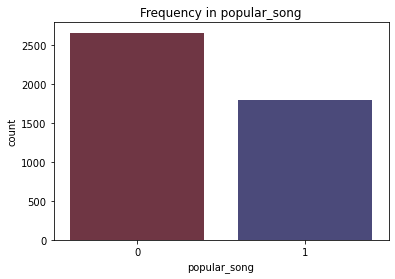

In [42]:
make_plot_count('popular_song', negative_one)

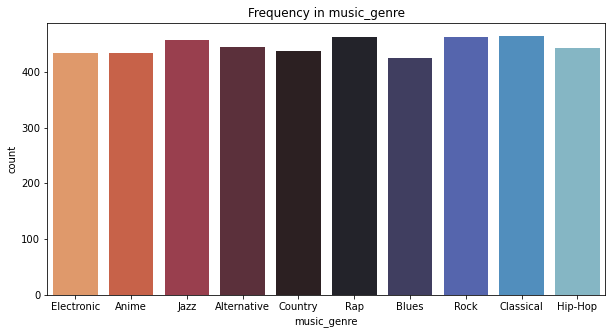

In [43]:
plt.figure(figsize = (10, 5))
make_plot_count('music_genre', negative_one)

For the sake of accuracy in our model we will be dropping the tracks that have a duration of -1.0 since it could negatively impact our model. Based on the Spotify search feature, the correct track duration_ms is provided as well.

In [44]:
df.drop(df[df['duration_ms'] == -1.0].index, inplace = True)
df.shape

(40560, 17)

In [45]:
df['duration_ms'] = convert_dtype(df['duration_ms'],'int64')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40560 entries, 1 to 50004
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       40560 non-null  object 
 1   track_name        40560 non-null  object 
 2   popularity        40560 non-null  int64  
 3   acousticness      40560 non-null  float64
 4   danceability      40560 non-null  float64
 5   duration_ms       40560 non-null  int64  
 6   energy            40560 non-null  float64
 7   instrumentalness  40560 non-null  float64
 8   key               40560 non-null  object 
 9   liveness          40560 non-null  float64
 10  loudness          40560 non-null  float64
 11  mode              40560 non-null  object 
 12  speechiness       40560 non-null  float64
 13  tempo             40560 non-null  float64
 14  valence           40560 non-null  float64
 15  music_genre       40560 non-null  object 
 16  popular_song      40560 non-null  int64 

### Mode

Mode is based on whether the key of the track is major or minor. At a music theory stand point, the difference between the two is that a Major scale has a natural third (whole step) when going up the scale and a Minor scale consists of a minor third (half step) when going up the scale. (Knowledge based on being an orchestra dork during my adolescence)

* Change mode key signature values from 'Major': 1 and 'Minor': 0
* Convert dtype to int

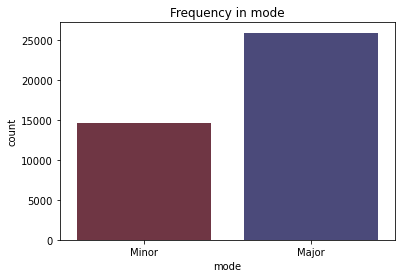

In [47]:
make_plot_count('mode', df)

In [48]:
df['mode'] = df['mode'].map(lambda x: 1 if x == 'Major' else 0)
df

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,popular_song
1,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.950000,D,0.124,-7.043,0,0.0300,115.002,0.531,Electronic,0
2,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.011800,G#,0.534,-4.617,1,0.0345,127.994,0.333,Electronic,0
3,Dubloadz,Nitro,34,0.02540,0.774,166875,0.700,0.002530,C#,0.157,-4.498,1,0.2390,128.014,0.270,Electronic,0
4,What So Not,Divide & Conquer,32,0.00465,0.638,222369,0.587,0.909000,F#,0.157,-6.266,1,0.0413,145.036,0.323,Electronic,0
6,Jordan Comolli,Clash,46,0.02890,0.572,214408,0.803,0.000008,B,0.106,-4.294,1,0.3510,149.995,0.230,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999,Night Lovell,Barbie Doll,56,0.13300,0.849,237667,0.660,0.000008,C,0.296,-7.195,1,0.0516,99.988,0.629,Hip-Hop,1
50001,Roy Woods,Drama (feat. Drake),72,0.15700,0.709,251860,0.362,0.000000,B,0.109,-9.814,1,0.0550,122.043,0.113,Hip-Hop,1
50002,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0.000000,D,0.143,-5.443,1,0.1460,131.079,0.395,Hip-Hop,1
50003,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0.000000,G,0.106,-5.016,0,0.0441,75.886,0.354,Hip-Hop,1


In [49]:
df.value_counts('mode')

mode
1    25959
0    14601
dtype: int64

In [50]:
df['mode'] = convert_dtype(df['mode'],'int64')

### Key

The key signature is based on the music scale from C, C#, D, D#... etc. to B, B#. The method is to set a numeric value for each key as C = 1, C# = 2

In [51]:
df.value_counts('key')

key
G     4630
C     4467
C#    4445
D     4244
A     3947
F     3486
B     3074
E     3030
G#    2729
A#    2721
F#    2484
D#    1303
dtype: int64

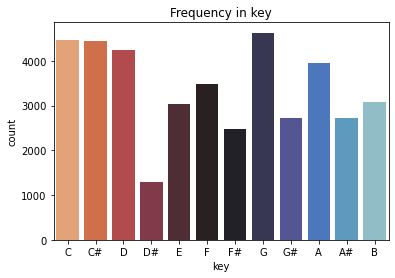

In [52]:
make_plot_count('key', df, order = ['C', 'C#', 'D', 'D#' , 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])

In [60]:
keysig = ['C', 'C#', 'D', 'D#' , 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
keysig_series = pd.Series(keysig)
keysig_cat = keysig_series.astype('category')
keysig_cat

0      C
1     C#
2      D
3     D#
4      E
5      F
6     F#
7      G
8     G#
9      A
10    A#
11     B
dtype: category
Categories (12, object): ['A', 'A#', 'B', 'C', ..., 'F', 'F#', 'G', 'G#']

In [62]:
# change the key signature category to numeric values using a label encoder
# if this is okay for the key signature or use onehotencode
# check RMSE for error difference
label_encoder = LabelEncoder()
df['key'] = label_encoder.fit_transform(df['key']).astype('int64')

In [65]:
df

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,popular_song
1,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.950000,5,0.124,-7.043,0,0.0300,115.002,0.531,Electronic,0
2,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.011800,11,0.534,-4.617,1,0.0345,127.994,0.333,Electronic,0
3,Dubloadz,Nitro,34,0.02540,0.774,166875,0.700,0.002530,4,0.157,-4.498,1,0.2390,128.014,0.270,Electronic,0
4,What So Not,Divide & Conquer,32,0.00465,0.638,222369,0.587,0.909000,9,0.157,-6.266,1,0.0413,145.036,0.323,Electronic,0
6,Jordan Comolli,Clash,46,0.02890,0.572,214408,0.803,0.000008,2,0.106,-4.294,1,0.3510,149.995,0.230,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999,Night Lovell,Barbie Doll,56,0.13300,0.849,237667,0.660,0.000008,3,0.296,-7.195,1,0.0516,99.988,0.629,Hip-Hop,1
50001,Roy Woods,Drama (feat. Drake),72,0.15700,0.709,251860,0.362,0.000000,2,0.109,-9.814,1,0.0550,122.043,0.113,Hip-Hop,1
50002,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0.000000,5,0.143,-5.443,1,0.1460,131.079,0.395,Hip-Hop,1
50003,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0.000000,10,0.106,-5.016,0,0.0441,75.886,0.354,Hip-Hop,1


In [66]:
df['key'] = convert_dtype(df['key'],'int64')

### Unique 

In [ ]:
# we can drop artist_name because we are not using it for our findings
# 2489 entries
df[df['artist_name'] == 'empty_field']